<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Improvements-pursued-in-this-notebook" data-toc-modified-id="Improvements-pursued-in-this-notebook-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Improvements pursued in this notebook</a></span></li></ul></li><li><span><a href="#First-round-of-improvements:-multi-label-classifier-&amp;-sessions" data-toc-modified-id="First-round-of-improvements:-multi-label-classifier-&amp;-sessions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>First round of improvements: multi-label classifier &amp; sessions</a></span><ul class="toc-item"><li><span><a href="#Tools-for-data,-model,-and-training" data-toc-modified-id="Tools-for-data,-model,-and-training-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tools for data, model, and training</a></span><ul class="toc-item"><li><span><a href="#Train-model-once-(to-test-if-it's-working)" data-toc-modified-id="Train-model-once-(to-test-if-it's-working)-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Train model once (to test if it's working)</a></span></li><li><span><a href="#Train-model-many-times-(to-understand-its-performance)" data-toc-modified-id="Train-model-many-times-(to-understand-its-performance)-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train model many times (to understand its performance)</a></span></li><li><span><a href="#Diving-into-results-of-a-single-session" data-toc-modified-id="Diving-into-results-of-a-single-session-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Diving into results of a single session</a></span></li></ul></li></ul></li></ul></div>

## Improvements pursued in this notebook

1. Change from binary classifier to multi category classifier:
    - add ims 0-9
    - add change loss fxn to cross entropy loss w/ softmax
    - change shape of final activation from 1 to 10
    - change label to 1HE
2. Add RGB

Super-short version with all of the helpers:

# First round of improvements: multi-label classifier & sessions

## Tools for data, model, and training

In [ ]:
from fastai.vision.all import *

### Data ###
def init_data(path, im_size, n_cls, batch_size):
    ## Train
    # ims
    for i in range(n_cls):
        new_ims = torch.stack(
            [tensor(Image.open(fn)) for fn in (path/'training'/f'{i}').ls()]
        ).float()/255
        if i == 0: ims = new_ims
        else: ims = torch.cat([ims,new_ims])
    train_ims = ims.view(-1,im_size)
    # lbls
    train_lbls = []
    for i in range(n_cls):
        l = L([0]*n_cls)
        l[i] = 1
        train_lbls += [l] * len((path/'training'/f'{i}').ls())    
    train_lbls = tensor(train_lbls)
    ## Valid
    # ims
    for i in range(n_cls):
        new_ims = torch.stack(
            [tensor(Image.open(fn)) for fn in (path/'testing'/f'{i}').ls()]
        ).float()/255
        if i == 0: ims = new_ims
        else: ims = torch.cat([ims,new_ims])
    valid_ims = ims.view(-1,im_size)
    # lbls
    valid_lbls = []
    for i in range(n_cls):
        l = L([0]*n_cls)
        l[i] = 1
        valid_lbls += [l] * len((path/'testing'/f'{i}').ls())    
    valid_lbls = tensor(valid_lbls)
    ## DataLoaders
    train_ds = L(zip(train_ims, train_lbls))
    valid_ds = L(zip(valid_ims, valid_lbls))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    return train_dl

### Model ###
def init_mod(im_size, n_cls, hidden_params):
    mod = nn.Sequential(
        nn.Linear(im_size,hidden_params),
        nn.ReLU(),
        nn.Linear(hidden_params,n_cls)
    )
    return mod

### Loss ###
def softmax(t):
    if len(t.shape) == 1: return torch.exp(t) / torch.exp(t).sum()
    else:                 return torch.exp(t) / torch.exp(t).sum(dim=1, keepdim=True)
def loss(yp, y):
    return (1 - (y*softmax(yp)).sum(dim=1, keepdim=True)).mean()

### Calculate gradients for use in train_once ###
def calc_grad(x,y,mod):
    yp = mod(x)     # get predictions
    ls = loss(yp,y) # calculate loss
    ls.backward()   # take gradient w.r.t. loss

### Create SGD Stepper; args = (mod.parameters(), lr) ###
class ParamStepper:
    def __init__(self, p, lr): self.p,self.lr = list(p),lr # initialize w/ mod.params & lr
        
    def step(self, *args, **kwargs):                       # take step
        for o in self.p: o.data -= o.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):                  # reset grad
        for o in self.p: o.grad = None

### Train parameters by performing SGD on each mini-batch in the dl ###
def train_one_epoch(dl, mod, stepper):
    for xb,yb in dl:           # for every minibatch (xb,yb) in the dataloader:
        calc_grad(xb, yb, mod) # calc grad(loss(mod(xb),yb))
        stepper.step()         # take step
        stepper.zero_grad()    # reset grad

### Get accuracy of mod on a mini-batch ###
def mb_acc(yp,y):
    yp_max,yp_i = torch.max(yp, dim=1, keepdim=True)
    y_max, y_i  = torch.max(y,  dim=1, keepdim=True)
    return (yp_i==y_i).float().mean()
        
### Get accuracy of mod on a dataloader (takes avg of all mbs in dl) ###
def epoch_acc(dl, mod):
    a = [mb_acc(mod(xb), yb) for xb,yb in dl]
    return round(torch.stack(a).mean().item(), 5)          # avg acc over all mini-batches

### Run `train_once` `epochs` times given data `dl`, model `mod`, and stepper `stepper`
def train_n_epochs(dl, mod, stepper, nepochs):
    accs = L()
    for i in range(nepochs):
        print('.',end='')
        train_one_epoch(dl, mod, stepper)
        accs += epoch_acc(dl, mod)
    print('',end='\t')
    return accs

### Perform n training sessions ###
def train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions):
    accs = L()
    mods = L()
    print('Progress:',end='\n')
    for i in range(nsessions):
        print(i,end='')
        mod = init_mod(im_size, n_cls, hidden_params)
        stepper = ParamStepper(mod.parameters(), lr)
        accs += train_n_epochs(dl, mod, stepper, nepochs)
        mods += mod
        
    # repack mods into nn.Sequential form
    nmods = len(mods)
    trained_models = L()
    for n in range(nsessions):
        layers = L()
        for j in range(nmods//nsessions): layers.append(mods.pop())
        layers.reverse()
        seqmod = nn.Sequential(*layers.items)
        trained_models += [seqmod]
        
    print('Done')
    return accs, trained_models

### Train model once (to test if it's working)

In [ ]:
# params
path          = untar_data(URLs.MNIST)
n_cls         = 10
im_size       = 28*28
batch_size    = 64*2*2*2
hidden_params = 30
lr            = .1
nepochs       = 20

# inits
dl            = init_data(path, im_size, n_cls, batch_size)
mod           = init_mod(im_size, n_cls, hidden_params)
stepper       = ParamStepper(mod.parameters(), lr)

# train
train_n_epochs(dl, mod, stepper, nepochs)

....................	

(#20) [0.1911,0.46966,0.64053,0.65437,0.66237,0.66664,0.73297,0.74156,0.74684,0.74923...]

### Train model many times (to understand its performance)

In [ ]:
# params
path          = untar_data(URLs.MNIST)
n_cls         = 10
im_size       = 28*28
batch_size    = 64*2*2*2
hidden_params = 30
nepochs       = 3
lr            = .1
nsessions     = 2

# inits
# dl = init_data(path, im_size, n_cls, batch_size)

# train
accs,mods = train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions)
accs_t = tensor(accs).reshape(nsessions,nepochs)

# print max acc
print("Max accuracy:",accs_t.max().item())

# print training sessions
pd.DataFrame(accs_t.numpy())

Progress:
0...	1...	Done
Max accuracy: 0.7045300006866455


,0,1,2
0,0.31146,0.46612,0.48164
1,0.19789,0.36898,0.70453


### Diving into results of a single session

In [ ]:
xb,yb = list(dl)[0]

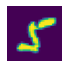

In [ ]:
show_image(xb[0].view(28,28))

In [ ]:
yb[0]

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
ypb = mods[0](xb)

In [ ]:
softmax(ypb[0])

tensor([8.8069e-04, 4.1182e-02, 3.6174e-02, 1.2745e-02, 8.9230e-02, 3.8748e-04,
        1.3135e-02, 7.4666e-03, 7.9591e-01, 2.8935e-03],
       grad_fn=<DivBackward0>)

It thought the five was an 8.